Predicted classes: [0 1 2]


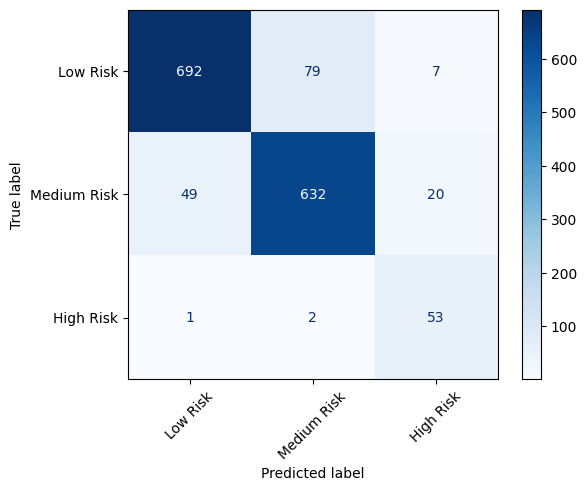

Macro-averaged F1 Score: 0.8613

Classification Report:
              precision    recall  f1-score   support

    Low Risk       0.93      0.89      0.91       778
 Medium Risk       0.89      0.90      0.89       701
   High Risk       0.66      0.95      0.78        56

    accuracy                           0.90      1535
   macro avg       0.83      0.91      0.86      1535
weighted avg       0.90      0.90      0.90      1535

Mean CV accuracy: 0.9181993634005771


NameError: name 'numeric_data' is not defined

In [2]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "True"
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import torch
import torch.nn as nn
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from mord import LogisticAT
from sklearn.metrics import f1_score, classification_report

class TorchLSTM(nn.Module):
    
    def __init__(self, input_size, hidden_size, num_classes, random_state=None):
        super(TorchLSTM, self).__init__()
        if random_state is not None:
            torch.manual_seed(random_state)
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(0.7)  
        self.fc = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.dropout(out)  # Apply dropout
        out = self.fc(out[:, -1, :])
        return out
        
    def fit(self, X, y, epochs=10, lr=0.001):
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=lr)
        
        X_tensor = torch.FloatTensor(X)
        y_tensor = torch.LongTensor(y)
        
        for epoch in range(epochs):
            optimizer.zero_grad()
            outputs = self(X_tensor)
            loss = criterion(outputs, y_tensor)
            loss.backward()
            optimizer.step()
        return self
        
    def predict_proba(self, X):
        self.eval()
        with torch.no_grad():
            X_tensor = torch.FloatTensor(X)
            outputs = torch.softmax(self(X_tensor), dim=1)
            return outputs.cpu().numpy()
            
    def extract_features(self, X):
        self.eval()
        with torch.no_grad():
            X_tensor = torch.FloatTensor(X)
            _, (hidden, _) = self.lstm(X_tensor)
            return hidden[-1].cpu().numpy()

def noNegatives(x):
    return max(x, 0)

# Load and clean data
df = pd.read_csv("/Users/reginasuriel/.cache/kagglehub/datasets/dnkumars/industrial-equipment-monitoring-dataset/versions/1/equipment_anomaly_data.csv")
df['vibration'] = df['vibration'].apply(noNegatives)
df['pressure'] = df['pressure'].apply(noNegatives)

# Define features
numeric_features = ['temperature', 'pressure', 'vibration', 'humidity']
categorical_features = ['equipment', 'location']
tabular_features = numeric_features + categorical_features

# Cluster analysis pipeline
cluster_preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

cluster_pipeline = Pipeline([
    ('preprocessor', cluster_preprocessor),
    ('pca', PCA(n_components=3)),
    ('cluster', KMeans(n_clusters=3, random_state=42, init='k-means++', n_init=20))
])

cluster_pipeline.fit(df[tabular_features])
df['cluster'] = cluster_pipeline.named_steps['cluster'].labels_

# Cluster ordering and risk assignment
distances = np.linalg.norm(cluster_pipeline.named_steps['cluster'].cluster_centers_, axis=1)
cluster_labels = distances.argsort()
cluster_to_order = {label: idx for idx, label in enumerate(cluster_labels)}
df['ordered_cluster'] = df['cluster'].map(cluster_to_order)

cluster_to_risk = {1: 'Low Risk', 0: 'Medium Risk', 2: 'High Risk'}
df['risk_level'] = df['cluster'].map(cluster_to_risk)
risk_to_ordinal = {'Low Risk': 0, 'Medium Risk': 1, 'High Risk': 2}
df['ordinal_label'] = df['risk_level'].map(risk_to_ordinal)


X_train, X_test, y_train, y_test = train_test_split(
    df[tabular_features], 
    df['ordinal_label'],  # Use ordinal labels here
    test_size=0.2, 
    random_state=100
)


y_train = y_train.astype(int)

# Time series data for LSTM
X_time_train = df.loc[X_train.index, numeric_features].values
X_time_test = df.loc[X_test.index, numeric_features].values
X_time_train = X_time_train.reshape(X_time_train.shape[0], X_time_train.shape[1], 1)
X_time_test = X_time_test.reshape(X_time_test.shape[0], X_time_test.shape[1], 1)

# Tabular data for Random Forest
X_tab_train = X_train
X_tab_test = X_test

# Model pipelines
model_preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

rf_pipeline = Pipeline([
    ('preprocessor', model_preprocessor),
    ('classifier', RandomForestClassifier(
        random_state=42,
        max_depth=5,           # Limit tree depth
        min_samples_split=5,   # Require more samples to split
        min_samples_leaf=2,    # Require more samples per leaf
        max_features='sqrt'    # Limit features considered at each split
    ))
])



lstm_model = TorchLSTM(
    input_size=X_time_train.shape[2],
    hidden_size=32,
    num_classes=3
)
lstm_model.fit(X_time_train, y_train)
rf_pipeline.fit(X_tab_train, y_train)

# Feature extraction
lstm_features_train = lstm_model.extract_features(X_time_train)
lstm_features_test = lstm_model.extract_features(X_time_test)
rf_proba_train = rf_pipeline.predict_proba(X_tab_train)
rf_proba_test = rf_pipeline.predict_proba(X_tab_test)

# Stack features
ordinal_labels_train = df.loc[y_train.index, 'ordinal_label'].values.reshape(-1, 1)
ordinal_labels_test = df.loc[y_test.index, 'ordinal_label'].values.reshape(-1, 1)

ordinal_labels_train = ordinal_labels_train.astype(int)

# Train features: Only use LSTM features + RF probabilities
stacked_features_train = np.hstack([
    lstm_features_train,
    rf_proba_train
    
])

# Test features: Same structure as train
stacked_features_test = np.hstack([
    lstm_features_test,
    rf_proba_test
])


ordinal_model = LogisticAT(alpha = 1.0, max_iter=1000)

from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy={0: 3100, 1: 3100, 2: 3100},  
              random_state=100)

# Apply SMOTE to the training data
stacked_features_train_balanced, y_train_balanced = smote.fit_resample(
    stacked_features_train, y_train
)

from sklearn.utils.class_weight import compute_sample_weight

sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

ordinal_model.fit(stacked_features_train, y_train, sample_weight=sample_weights)

y_pred = ordinal_model.predict(stacked_features_test)

print("Predicted classes:", np.unique(y_pred))

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Low Risk', 'Medium Risk', 'High Risk'])
disp.plot(cmap='Blues', xticks_rotation=45)
plt.show()

f1_macro = f1_score(y_test, y_pred, average='macro')
print(f"Macro-averaged F1 Score: {f1_macro:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Low Risk', 'Medium Risk', 'High Risk']))

from sklearn.model_selection import cross_val_score

scores = cross_val_score(ordinal_model, stacked_features_train, y_train, cv=5, scoring='accuracy')
print("Mean CV accuracy:", np.mean(scores))

#BEGIN SYNTHETIC TESTING

# Define number of samples with controlled class distribution
n_samples = 10000
class_distribution = {'Low Risk': 0.6, 'Medium Risk': 0.3, 'High Risk': 0.1}  

# Generate numeric data with risk-dependent patterns
def generate_numeric_data(n_samples):
    data = {
        'temperature': [],
        'vibration': [],
        'pressure': [],
        'humidity': []
    }
    
    for _ in range(n_samples):
        risk = np.random.choice(['Low Risk', 'Medium Risk', 'High Risk'], 
                               p=[class_distribution['Low Risk'], 
                                 class_distribution['Medium Risk'], 
                                 class_distribution['High Risk']])
        
        if risk == 'Low Risk':
            data['temperature'].append(np.random.normal(loc=65, scale=3))
            data['vibration'].append(np.random.normal(loc=1.0, scale=0.2))
            data['pressure'].append(np.random.normal(loc=90, scale=5))
            data['humidity'].append(np.random.normal(loc=45, scale=10))
        elif risk == 'Medium Risk':
            data['temperature'].append(np.random.normal(loc=75, scale=4))
            data['vibration'].append(np.random.normal(loc=1.5, scale=0.3))
            data['pressure'].append(np.random.normal(loc=110, scale=8))
            data['humidity'].append(np.random.normal(loc=55, scale=12))
        else:  # High Risk
            data['temperature'].append(np.random.normal(loc=85, scale=6))
            data['vibration'].append(np.random.normal(loc=2.0, scale=0.5))
            data['pressure'].append(np.random.normal(loc=130, scale=15))
            data['humidity'].append(np.random.normal(loc=65, scale=20))
    
    return data

# Generate categorical data with some meaningful patterns
def generate_categorical_data(n_samples):
    equipment = []
    location = []
    
    for _ in range(n_samples):
        # PlantA tends to have more High Risk cases
        loc = np.random.choice(['PlantA', 'PlantB', 'PlantC'], 
                              p=[0.4, 0.3, 0.3])
        
        if loc == 'PlantA':
            equip = np.random.choice(['Engine1', 'Engine2', 'Engine3'],
                                   p=[0.5, 0.3, 0.2])  # Engine1 more common in PlantA
        else:
            equip = np.random.choice(['Engine1', 'Engine2', 'Engine3'],
                                   p=[0.3, 0.4, 0.3])
        
        equipment.append(equip)
        location.append(loc)
    
    return {'equipment': equipment, 'location': location}

df_synthetic = pd.DataFrame({**numeric_data, **categorical_data})

# Create risk levels and preprocess
conditions = [
    (df_synthetic['temperature'] > 80) | (df_synthetic['pressure'] > 120),
    (df_synthetic['temperature'] > 70) | (df_synthetic['pressure'] > 100),
    (df_synthetic['temperature'] <= 70) & (df_synthetic['pressure'] <= 100)
]
choices = ['High Risk', 'Medium Risk', 'Low Risk']
df_synthetic['risk_level'] = np.select(conditions, choices)

# Add noise
noise_mask = np.random.random(n_samples) < 0.05
df_synthetic.loc[noise_mask, 'risk_level'] = np.random.choice(['Low Risk', 'Medium Risk', 'High Risk'])

# Convert to ordinal labels
risk_to_ordinal = {'Low Risk': 0, 'Medium Risk': 1, 'High Risk': 2}
y_ordinal = df_synthetic['risk_level'].map(risk_to_ordinal).values

# Preprocessing pipeline
numeric_features = ['temperature', 'vibration', 'pressure', 'humidity']
categorical_features = ['equipment', 'location']

# Scale numeric features
scaler = StandardScaler()
df_synthetic[numeric_features] = scaler.fit_transform(df_synthetic[numeric_features])

# One-hot encode categorical features
encoder = OneHotEncoder(handle_unknown='ignore')
encoded_cats = encoder.fit_transform(df_synthetic[categorical_features])

encoded_cat_cols = encoder.get_feature_names_out(categorical_features)

encoded_cats_dense = encoded_cats.toarray()

df_encoded = pd.DataFrame(encoded_cats_dense, columns=encoded_cat_cols)

# Prepare final dataset
df_processed = pd.concat([df_synthetic[numeric_features], df_encoded], axis=1)
y = df_synthetic['risk_level']

# Split FIRST (before any resampling)
X_train, X_test, y_train, y_test = train_test_split(
    df_synthetic[numeric_features + categorical_features],
    y_ordinal,
    test_size=0.2,
    random_state=42
)

# Preprocess categorical features for SMOTE
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Apply preprocessing to training data
X_train_preprocessed = preprocessor.fit_transform(X_train)

# Apply SMOTE only to preprocessed training data
smote = SMOTE(sampling_strategy={0: 5800, 1: 5800, 2: 5800}, random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_preprocessed, y_train)

# For LSTM: Get original numeric features from resampled indices
# (We need to inverse transform the resampled data to get back to original scale)
X_train_num = preprocessor.named_transformers_['num'].inverse_transform(
    X_train_resampled[:, :len(numeric_features)]
)
time_series_train = X_train_num.reshape(-1, len(numeric_features), 1)

# For RF: We can use the resampled preprocessed data directly
X_tab_train = X_train_resampled
X_tab_test = preprocessor.transform(X_test)

# Train models
lstm_model.fit(time_series_train, y_train_resampled)

rf_pipeline = Pipeline([
    ('classifier', RandomForestClassifier(
        random_state=42,
        max_depth=5,
        min_samples_split=5,
        min_samples_leaf=2,
        max_features='sqrt'
    ))
])
rf_pipeline.fit(X_tab_train, y_train_resampled)

# Feature extraction
lstm_features_train = lstm_model.extract_features(time_series_train)
rf_proba_train = rf_pipeline.predict_proba(X_tab_train)

# Stack features
stacked_features_train = np.hstack([lstm_features_train, rf_proba_train])

time_series_test = X_test[numeric_features].values.reshape(-1, len(numeric_features), 1)
rf_proba_test = rf_pipeline.predict_proba(X_tab_test)

stacked_features_test = np.hstack([
    lstm_model.extract_features(time_series_test),
    rf_proba_test
])


# 5. If still mismatched, recreate your test set processing:
# Instead of using X_test directly, use:
X_test_processed = preprocessor.transform(X_test[numeric_features + categorical_features])
time_series_test = X_test[numeric_features].values.reshape(-1, len(numeric_features), 1)
rf_proba_test = rf_pipeline.predict_proba(X_test_processed)
stacked_features_test = np.hstack([
    lstm_model.extract_features(time_series_test),
    rf_proba_test
])
y_pred = ordinal_model.predict(stacked_features_test)

# Now generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, 
                            display_labels=['Low Risk', 'Medium Risk', 'High Risk'])
disp.plot(cmap='Blues', xticks_rotation=45)
plt.show()